## Fisher Analysis 1
#### Just doing Fisher Analysis of weak lensing convergence field with 2-pint function.
#### So remember:
$$
F_{\Omega_m,\sigma_8}\approx\left(\frac{\Delta C_l}{\Delta \theta}\right)^T\hat{C}^{-1}\left(\frac{\Delta C_l}{\Delta \theta}\right)
$$
#### where $\hat{C}^{-1}$ is the data covariance.
#### It is derived using Taylor expansion. So many news paper is always talking about Einstein oder Newton, but why noone Taylor?
#### From now, I am Taylorian, if Bayesian is possible, Taylorian must sound also nice! But Fisherian might be problem.
#### This notebook corresponds to Chapter 8.4 and figure 8.16 of my thesis.

In [2]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
from astropy.io import fits
from classy import Class
from scipy import integrate
import ctypes
import sys
import numpy as np
import os
os.chdir("/home/r/R.Kanaki/Master_Arbeit_Final/MCMC_Modelling")
from Limber_Model import Kappa_Powerspecrum_T17 as Limber

# Part 1. Derivativ

In [4]:
Cl_data = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/bin34/T17_downgraded_to_128_Cl.npz')
Cl_T17      = Cl_data['convergence powerspectrum']
Cl_data = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_Gauss_Cl.npz')
Cl_Gauss      = Cl_data['convergence powerspectrum']
Cl_data = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_lognormal_Cl.npz')
Cl_lognormal  = Cl_data['convergence powerspectrum']
Cl_T17_mean = np.mean(Cl_T17, axis=0)
Cl_T17_var = np.var(Cl_T17, axis=0)
Cl_Gauss_mean = np.mean(Cl_Gauss, axis=0)
Cl_Gauss_var  = np.var(Cl_Gauss, axis=0)
Cl_lognormal_mean = np.mean(Cl_lognormal, axis=0)
Cl_lognormal_var  = np.var(Cl_lognormal, axis=0)

In [5]:
num_sim_T17   = len(Cl_T17)
num_sim_Flask = len(Cl_lognormal)

ell = np.arange(len(Cl_T17_mean))
ell_max = np.max(ell)
ell_min = np.min(ell)
num_bins = 30
bin_edges = np.logspace(np.log10(ell_min+10), np.log10(ell_max), num=num_bins + 1)

binned_ell     = np.zeros(num_bins)
Data_T17       = np.zeros((num_sim_T17, num_bins))
Data_Gauss     = np.zeros((num_sim_Flask, num_bins))
Data_lognormal = np.zeros((num_sim_Flask, num_bins))

#### Like central derivative, sorry italian professor, I don't remember the name of both...

In [7]:
for i in range(num_bins):
    ell_mask = (ell >= bin_edges[i]) & (ell < bin_edges[i + 1])
    binned_ell[i] = np.mean(ell[ell_mask])
    
    for j in range(num_sim_T17):
        Data_T17[j, i] = np.mean(Cl_T17[j, ell_mask])
    
    for j in range(num_sim_Flask):
        Data_Gauss[j, i] = np.mean(Cl_Gauss[j, ell_mask])
        Data_lognormal[j, i] = np.mean(Cl_lognormal[j, ell_mask])

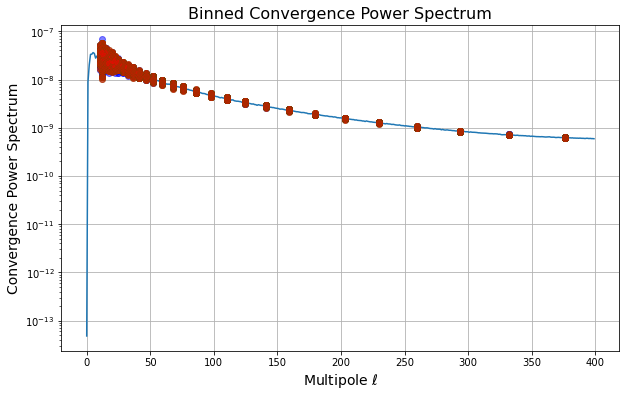

In [8]:
# Plot binned data for each simulation type
plt.figure(figsize=(10, 6))

for j in range(num_sim_T17):
    plt.errorbar(binned_ell, Data_T17[j], fmt='o', label=f'T17 Sim {j+1}', color='blue', alpha=0.5)

for j in range(num_sim_Flask):
    plt.errorbar(binned_ell, Data_Gauss[j], fmt='o', label=f'Gaussian Sim {j+1}', color='green', alpha=0.5)
    plt.errorbar(binned_ell, Data_lognormal[j], fmt='o', label=f'Lognormal Sim {j+1}', color='red', alpha=0.5)
plt.plot(ell,Cl_T17_mean)
plt.yscale('log')
plt.xlabel('Multipole $\\ell$', fontsize=14)
plt.ylabel('Convergence Power Spectrum', fontsize=14)
plt.title('Binned Convergence Power Spectrum', fontsize=16)
#plt.legend()
plt.grid()
plt.show()

#### グロテスク

In [10]:
# Creating an instance of the Limber class
limber_model = Limber()

# Example usage: Calculating the convergence power spectrum
Omega_m = 0.279
sigma_8 = 0.82
Cl_fid = limber_model.Cl(Omega_m, sigma_8)[:,1]

/home/r/R.Kanaki/Master_Arbeit_Final/MCMC_Modelling/Limber_Model.py:199: RuntimeWarning: divide by zero encountered in true_divide
  self.P[i]=self.P_NL(Cosmo,l/self.w[i], self.z_range[i])


In [11]:
Data_fid = np.zeros(num_bins)
for i in range(num_bins):
    ell_mask = (ell >= bin_edges[i]) & (ell < bin_edges[i + 1])
    binned_ell[i] = np.mean(ell[ell_mask])
    Data_fid[i] = np.mean(Cl_fid[ell_mask])

## Part 2. Covariance

#### Wick covariance
### The angular powerspectrum $\hat{C}_l$ is defined with the angular coefficient $a_{lm}$ following,
### $\hat{C}_l=\frac{1}{2l+1}\sum^{l}_{m=-l}a_{l,m}a^*_{l,m}$
### Then we consider the covariance of hits $\hat{C}_l$
### $\mathrm{Cov}(\hat{C}_{l_1},\hat{C}_{l_2})=\langle\hat{C}_{l_1}\hat{C}_{l_2}\rangle-\langle\hat{C}_{l_1}\rangle\langle\hat{C}_{l_2}\rangle$
### We consdier the first term $\langle\hat{C}_{l_1}\hat{C}_{l_2}\rangle$
### $\langle\hat{C}_{l_1}\hat{C}_{l_2}\rangle=\frac{1}{(2l_1+1)(2l_2+1)}\sum_{m_1,m_2}\langle a_{l_1 m_1}a^*_{l_1 m_1}a_{l_2 m_2}a^*_{l_2 m_2}\rangle$
### Assume the $a_{lm}$ is Gaussian, then we can apply the Wick's theorem, it yields
### $\langle a_{l_1 m_1}a^*_{l_1 m_1}a_{l_2 m_2}a^*_{l_2 m_2}\rangle=\langle a_{l_1 m_1}a^*_{l_1 m_1}\rangle+\langle a_{l_2 m_2}a^*_{l_2 m_2} \rangle+\langle a_{l_1 m_1}a_{l_2 m_2}\rangle+\langle a^*_{l_1 m_1}a^*_{l_2 m_2} \rangle+\langle a_{l_1 m_1}a^*_{l_2 m_2}\rangle+\langle a^*_{l_1 m_1}a_{l_2 m_2} \rangle = C_{l_1}C_{l_2}+2\delta_{l_1 l_2}C^2_{l_1}$
### Then we get the covariance,
### $\mathrm{Cov}(\hat{C}_{l_1},\hat{C}_{l_2})=\frac{2\delta_{l_1 l_2}}{2l_1+1}C^2_{l_1}$

In [12]:
def Wick_cov(C_l):
    num_l_values = len(C_l)
    cov_matrix = np.zeros((num_l_values, num_l_values))

    for i in range(num_l_values):
        for j in range(num_l_values):
            l1 = i + 1
            l2 = j + 1
            if l1 == l2:
                cov_matrix[i, j] = (2 * delta(l1, l2)) / ((2 * l1) + 1) * C_l[i]**2
            else:
                cov_matrix[i, j] = 0

    return cov_matrix

def delta(i, j):
    return int(i == j)

In [13]:
cov_Wick     = Wick_cov(Cl_fid.T)
cov_Wick_inv =  np.linalg.inv(cov_Wick)

#### Flask & T17 covariance
#### Covariance matrix formular for rich guys
#### $C_{i,j}=\frac{1}{N_s-1}\sum^{N_s}_{s=1}(C_l-\langle C_l\rangle)^T(C_l-\langle C_l\rangle)$
#### But rech guy must pay Kaufmann Harrtlap factor
#### $\hat{C}^{-1}=\frac{N_{sim}-1}{N_{sim}-N_{Data}-2}C^{-1}$

In [14]:
cov_T17              = np.cov(Data_T17.T)
cov_Gauss            = np.cov(Data_Gauss.T)
cov_lognormal        = np.cov(Data_lognormal.T)

In [15]:
def calculate_correlation_matrix(covariance_matrix):
    variances = np.diag(covariance_matrix)
    standard_deviations = np.sqrt(variances)
    precision_matrix = np.linalg.inv(np.diag(standard_deviations))
    correlation_matrix = covariance_matrix / np.outer(standard_deviations, standard_deviations)
    return correlation_matrix

In [16]:
corr_T17   = calculate_correlation_matrix(cov_T17)
corr_Gauss = calculate_correlation_matrix(cov_Gauss)
corr_Wick  = calculate_correlation_matrix(cov_Wick)

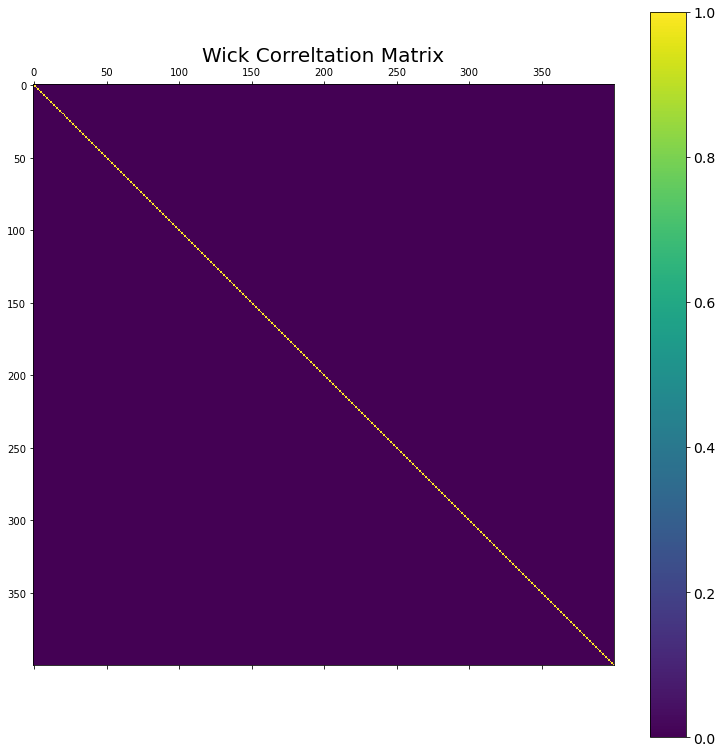

In [17]:
f = plt.figure(figsize=(13, 13))
plt.matshow(corr_Wick, fignum=f.number)
plt.title('Wick Correltation Matrix', fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/corr_Wick.png', dpi=300, bbox_inches='tight')

#### If every covariance is like that, so much easy so much simple world

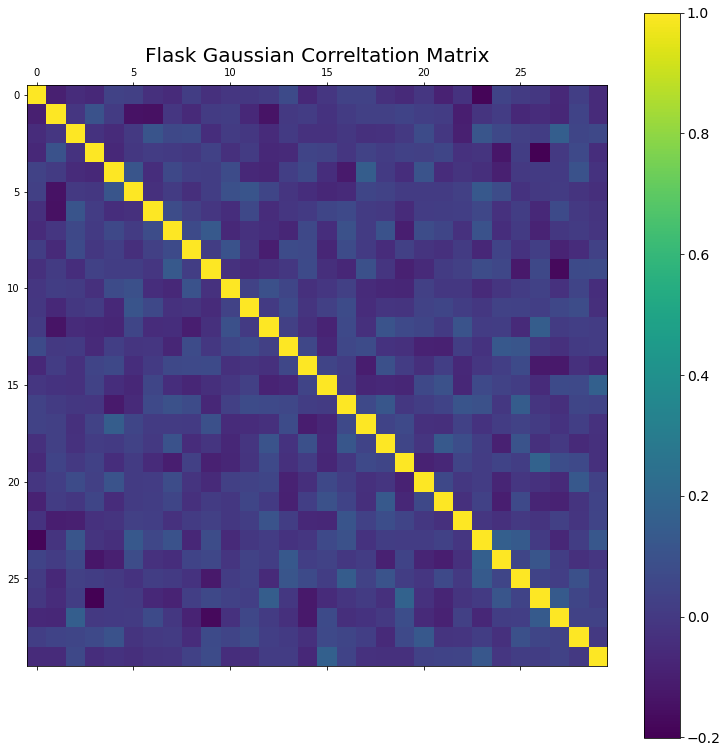

In [19]:
f = plt.figure(figsize=(13, 13))
plt.matshow(corr_Gauss, fignum=f.number)
plt.title('Flask Gaussian Correltation Matrix', fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/corr_Gauss.png', dpi=300, bbox_inches='tight')

#### You see, there is noise

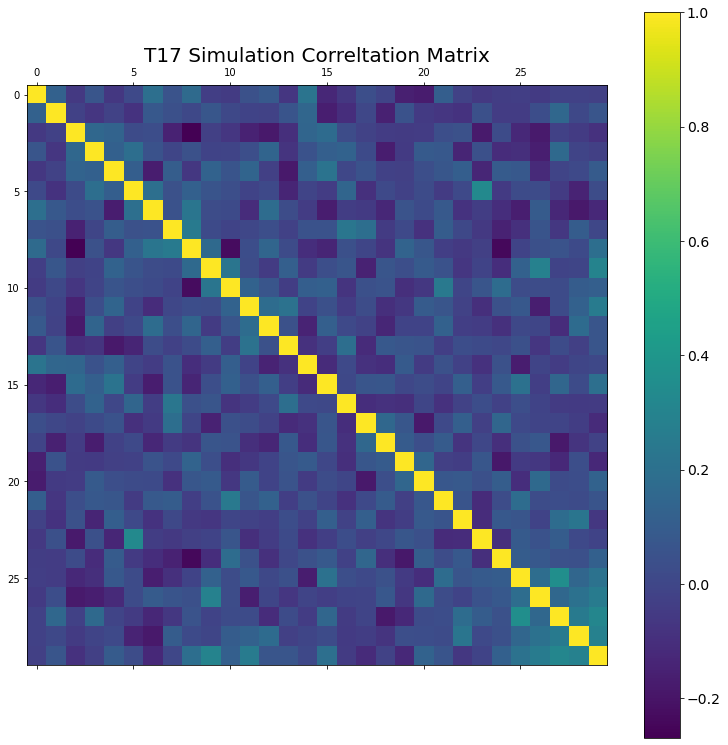

In [20]:
f = plt.figure(figsize=(13, 13))
plt.matshow(corr_T17, fignum=f.number)
plt.title('T17 Simulation Correltation Matrix', fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/T17.png', dpi=300, bbox_inches='tight')

In [21]:
KH_fac_T17         = (num_sim_T17-num_bins-2)/(num_sim_T17-1)
KH_fac_Flask       = (num_sim_Flask-num_bins-2)/(num_sim_Flask-1)
cov_T17_inv        = np.linalg.inv(cov_T17)*KH_fac_T17
cov_Gauss_inv      = np.linalg.inv(cov_Gauss)*KH_fac_Flask
cov_lognormal_inv  = np.linalg.inv(cov_lognormal)*KH_fac_Flask

## Part 4. Nochmal derivative?
#### Calculating via central difference
#### $\frac{\mathrm{d}f}{\mathrm{d}x}=\frac{f(x+h)-f(x-h)}{2h}$

In [22]:
Om_plu_005  = Omega_m+Omega_m*0.05
Om_mi_005   = Omega_m-Omega_m*0.05
Sig_plu_005 = sigma_8+sigma_8*0.05
Sig_mi_005  = sigma_8-sigma_8*0.05
delta_Om    = Omega_m*0.05
delta_Sig   = sigma_8*0.05

In [23]:
Cl_Om_plu  = limber_model.Cl(Om_plu_005, sigma_8)[:,1]
Cl_Om_mi   = limber_model.Cl(Om_mi_005, sigma_8)[:,1]
Cl_sig_plu = limber_model.Cl(Omega_m, Sig_plu_005)[:,1]
Cl_sig_mi  = limber_model.Cl(Omega_m, Sig_mi_005)[:,1]

In [24]:
Data_Om_plu  = np.zeros(num_bins)
Data_Om_mi   = np.zeros(num_bins)
Data_sig_plu = np.zeros(num_bins)
Data_sig_mi  = np.zeros(num_bins)
for i in range(num_bins):
    ell_mask = (ell >= bin_edges[i]) & (ell < bin_edges[i + 1])
    binned_ell[i]   = np.mean(ell[ell_mask])
    Data_Om_plu[i]  = np.mean(Cl_Om_plu[ell_mask])
    Data_Om_mi[i]   = np.mean(Cl_Om_mi[ell_mask])
    Data_sig_plu[i] = np.mean(Cl_sig_plu[ell_mask])
    Data_sig_mi[i]  = np.mean(Cl_sig_mi[ell_mask])

In [25]:
Abl_sim = np.zeros((2,30))
Abl_sim[0,:]  = (Data_Om_plu-Data_Om_mi)/(2*delta_Om)
Abl_sim[1,:]  = (Data_sig_plu-Data_sig_mi)/(2*delta_Sig)
Abl_ana = np.zeros((2,400))
Abl_ana[0,:]  = (Cl_Om_plu-Cl_Om_mi)/(2*delta_Om)
Abl_ana[1,:]  = (Cl_sig_plu-Cl_sig_mi)/(2*delta_Sig)

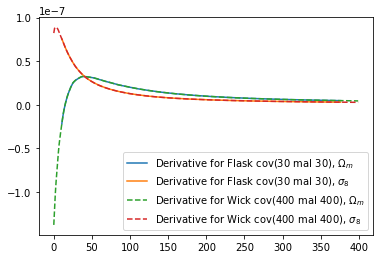

In [26]:
plt.plot(binned_ell, Abl_sim[0,:],label='Derivative for Flask cov(30 mal 30), $\Omega_m$')
plt.plot(binned_ell, Abl_sim[1,:],label='Derivative for Flask cov(30 mal 30), $\sigma_8$')
plt.plot(ell, Abl_ana[0,:],linestyle='dashed',label='Derivative for Wick cov(400 mal 400), $\Omega_m$')
plt.plot(ell, Abl_ana[1,:],linestyle='dashed',label='Derivative for Wick cov(400 mal 400), $\sigma_8$')
plt.legend()

In [27]:
F_Wick = np.zeros((2, 2))
F_Wick = np.matmul(np.matmul(Abl_ana, cov_Wick_inv),Abl_ana.T)
F_T17 = np.zeros((2, 2))
F_T17 = np.matmul(np.matmul(Abl_sim, cov_T17_inv),Abl_sim.T)
F_Flask = np.zeros((2, 2))
F_Flask = np.matmul(np.matmul(Abl_sim, cov_Gauss_inv),Abl_sim.T)

## Part 5. Plot Posterior
### $C_\theta=F^{-1}$

In [33]:
fid_cos=[Omega_m,sigma_8]

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
#import IPython
#print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

In [30]:
param_cov_Wick = np.linalg.inv(F_Wick)
param_cov_T17  = np.linalg.inv(F_T17)
param_cov_Flask= np.linalg.inv(F_Flask)

Removed no burn in
Removed no burn in
Removed no burn in


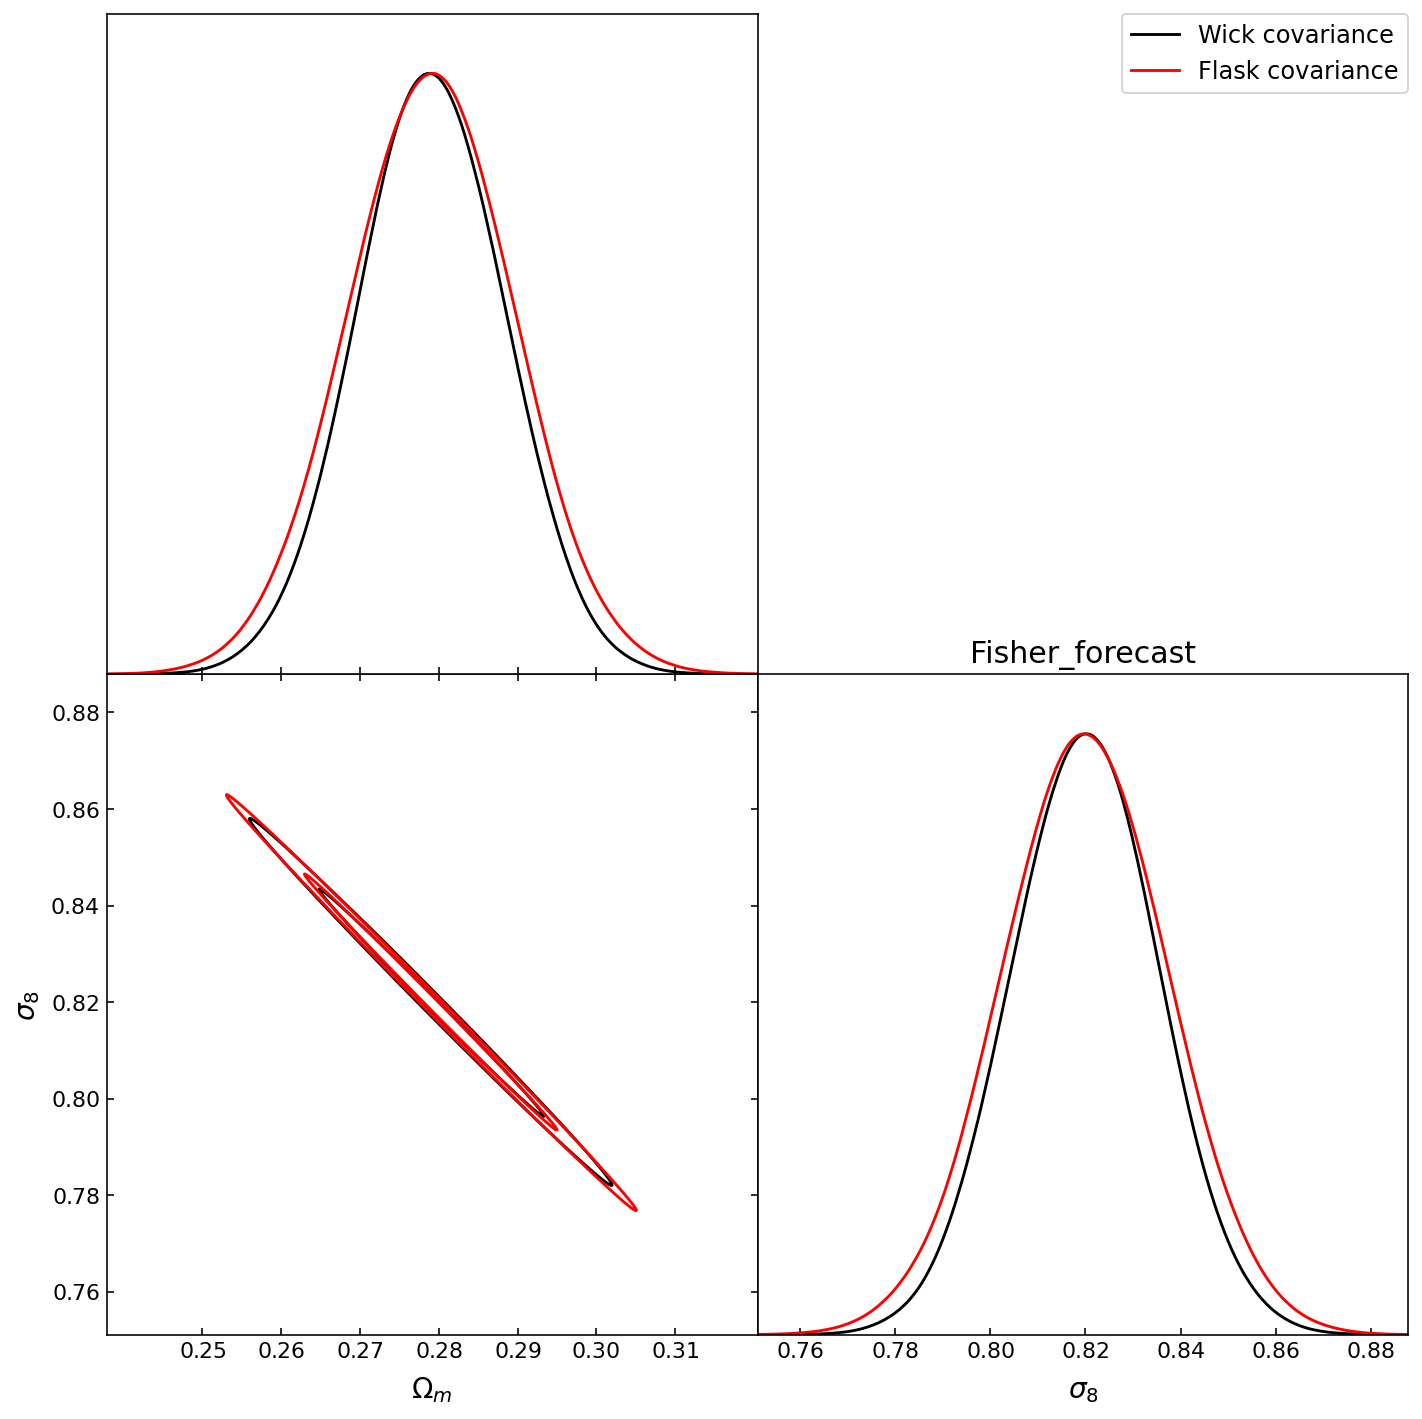

In [31]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
#T17 likelihood
nsamp = 100000
samples_Wick                = np.random.multivariate_normal(fid_cos, param_cov_Wick, size=nsamp)
samples_T17                 = np.random.multivariate_normal(fid_cos, param_cov_T17, size=nsamp)
samples_Flask               = np.random.multivariate_normal(fid_cos, param_cov_Flask, size=nsamp)
samples_Wick_mcsamples      = MCSamples(samples=samples_Wick, names=param_names, labels=param_names, label='Wick covariance', ranges=prior_ranges)
samples_T17_mcsamples       = MCSamples(samples=samples_T17, names=param_names, labels=param_names, label='Wick covariance', ranges=prior_ranges)
samples_Flask_mcsamples     = MCSamples(samples=samples_Flask, names=param_names, labels=param_names, label='Wick covariance')
all_samples_Fisher = [samples_Wick_mcsamples, samples_Flask_mcsamples]
labels = ['Wick covariance','Flask covariance']

# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)

# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_Fisher, filled=False, legend_labels=labels, legend_loc='upper right')
plt.title('Fisher_forecast',fontsize=15)
# Save the plot to a file (optional)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/Fisher_Forecast_test.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

#### That is high attack point. But so degenerated, entartet

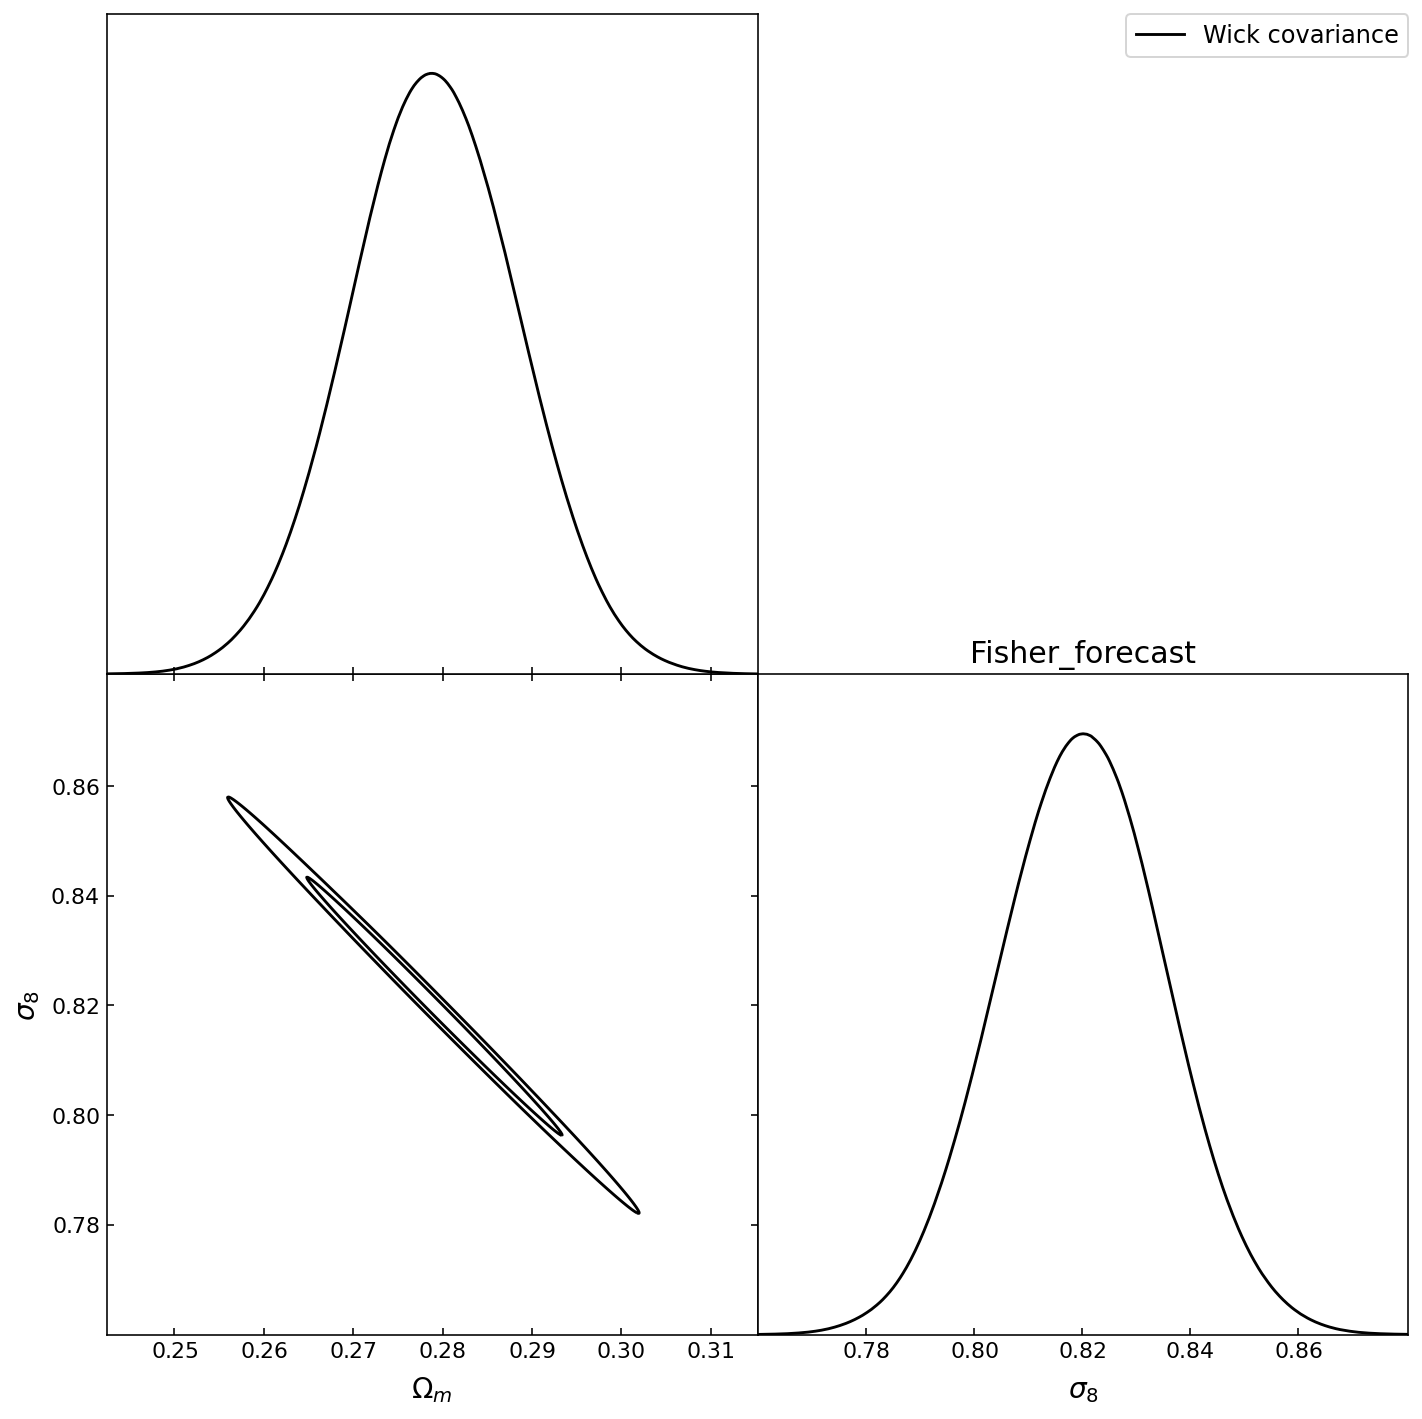

In [32]:
all_samples_Fisher = [samples_Wick_mcsamples]
labels = ['Wick covariance']

# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)

# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_Fisher, filled=False, legend_labels=labels, legend_loc='upper right')
plt.title('Fisher_forecast',fontsize=15)
# Save the plot to a file (optional)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v4/Fisher_Forecast_Wick.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()